### Importing necessary libraries

In [28]:
import math
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Creating a GPU device if available

In [29]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


### CNN Hyperparameters

In [30]:
image_base_size = 256
num_epochs = 10
batch_size = 10
learning_rate = 0.01

### Creating the dataset and loading in the monkeys

In [31]:


composed = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([image_base_size, image_base_size])  # Square images idea for CNN

])

class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = 0

        # Adding all monkeys to a list
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.number_samples += 1
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        # Read monkey image from directory name
        monkey = read_image(monkey_path)

        # Get monkey label from filename
        label = int(monkey_filename[1:2])  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms:
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        # This will allow len()
        return self.number_samples
    
    def get_label_map(self):
        print({i.strip():j.strip() for i, j in zip(self.img_labels.iloc[:, 0], self.img_labels.iloc[:, 2])})

    def get_label_map2(self):
        print({i.strip():j for i, j in zip(self.img_labels.iloc[:, 0], range(0, 10))})



# train_data = MonkeyDataset()
training_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)
validation_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/validation/validation",
    transform = composed
)

label2name = training_data.get_label_map()
label2num = training_data.get_label_map2()
pprint(label2name, label2num)

{'n0': 'mantled_howler', 'n1': 'patas_monkey', 'n2': 'bald_uakari', 'n3': 'japanese_macaque', 'n4': 'pygmy_marmoset', 'n5': 'white_headed_capuchin', 'n6': 'silvery_marmoset', 'n7': 'common_squirrel_monkey', 'n8': 'black_headed_night_monkey', 'n9': 'nilgiri_langur'}
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
None


### Testing dataloaders and showing example monkey

tensor([[[0.2667, 0.2617, 0.2569,  ..., 0.2235, 0.2270, 0.2275],
         [0.2644, 0.2609, 0.2544,  ..., 0.2221, 0.2235, 0.2264],
         [0.2623, 0.2578, 0.2509,  ..., 0.2196, 0.2221, 0.2231],
         ...,
         [0.1645, 0.1594, 0.1573,  ..., 0.2519, 0.2813, 0.3598],
         [0.1664, 0.1629, 0.1611,  ..., 0.2595, 0.2775, 0.3409],
         [0.1737, 0.1682, 0.1655,  ..., 0.2524, 0.2579, 0.3122]],

        [[0.3608, 0.3558, 0.3510,  ..., 0.2902, 0.2937, 0.2941],
         [0.3585, 0.3550, 0.3486,  ..., 0.2888, 0.2902, 0.2931],
         [0.3564, 0.3519, 0.3450,  ..., 0.2862, 0.2888, 0.2897],
         ...,
         [0.1841, 0.1790, 0.1769,  ..., 0.2284, 0.2578, 0.3363],
         [0.1860, 0.1825, 0.1807,  ..., 0.2360, 0.2540, 0.3173],
         [0.1934, 0.1878, 0.1851,  ..., 0.2289, 0.2344, 0.2887]],

        [[0.2275, 0.2225, 0.2098,  ..., 0.1647, 0.1682, 0.1686],
         [0.2252, 0.2217, 0.2074,  ..., 0.1633, 0.1647, 0.1676],
         [0.2231, 0.2185, 0.2039,  ..., 0.1607, 0.1633, 0.

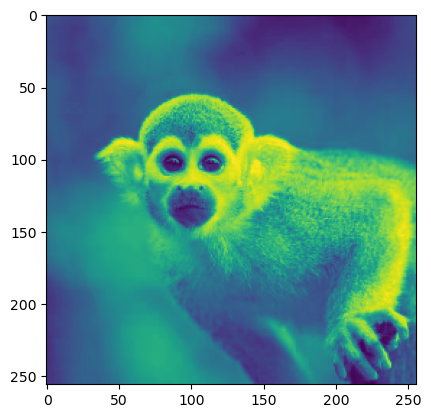

In [32]:
# dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

# iterating through the dataloader
train_features, train_labels = next(iter(train_dataloader))
print(train_features[0], train_labels)
print(train_features.size())  # batch size, channel count, image size
plt.imshow(train_features[0][0])
plt.show()

### Defining the CNN class

In [33]:
class CNN(nn.Module):
    def __init__(self) -> None:
        # torch.utils.data.Dataset doesn’t define its own __init__ so by calling super().__init__() you are not performing any meaningful actions. In comparison, calling super().__init__() when subclassing torch.nn.Module is required to initialize the internal data structures for storing buffers, modules, etc.
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        # self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # End up with size of 30 for the regular neural network
        self.full_con1 = nn.Linear(8*8*24, 2000)
        self.full_con2 = nn.Linear(2000, 500)
        self.full_con3 = nn.Linear(500, 10)
    
    def forward(self, x):
        # This whole first part is classification learning
        s = self.pool(F.leaky_relu(self.conv1(x)))  # Function takes in a tensor as input
        s = self.pool(F.leaky_relu(self.conv2(s)))
        s = self.pool(F.leaky_relu(self.conv3(s)))

        # Output channels * image width * image height
        s = torch.reshape(s, [-1, 8*8*24])
        s.size()
        # s = 

        # This whole second part is feature learning
        s = F.leaky_relu(self.full_con1(s))
        s = F.leaky_relu(self.full_con2(s))
        s = self.full_con3(s)

        return s

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (full_con1): Linear(in_features=1536, out_features=2000, bias=True)
  (full_con2): Linear(in_features=2000, out_features=500, bias=True)
  (full_con3): Linear(in_features=500, out_features=10, bias=True)
)


### Optimization code

In [34]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for iteration, (monkey, label) in enumerate(train_dataloader):
        monkey = monkey.to(device)
        label = label.to(device)
        # print(monkey.size(), label)

        # Forward pass
        # Pass on torch.Size([64, 3, 256, 256])
        pred = model.forward(monkey)
        # pred2 = model(monkey)
        # print(pred == pred2)

        # Clearing out optimizer grad
        optimizer.zero_grad()

        # Calculate loss
        # Target is a value between 0 and C
        # print(label)
        loss = loss_fn(pred, label)

        # Backward pass
        loss.backward()

        # Optimize (step)
        optimizer.step()

        print(f"Epoch: {epoch}, Iteration: {iteration}, Loss: {loss}")
        

Epoch: 0, Iteration: 0, Loss: 2.2930595874786377
Epoch: 0, Iteration: 1, Loss: 2.3165087699890137
Epoch: 0, Iteration: 2, Loss: 2.3032078742980957
Epoch: 0, Iteration: 3, Loss: 2.3075106143951416
Epoch: 0, Iteration: 4, Loss: 2.3058178424835205
Epoch: 0, Iteration: 5, Loss: 2.300570249557495
Epoch: 0, Iteration: 6, Loss: 2.301508665084839
Epoch: 0, Iteration: 7, Loss: 2.30361270904541
Epoch: 0, Iteration: 8, Loss: 2.3008546829223633
Epoch: 0, Iteration: 9, Loss: 2.3119359016418457
Epoch: 0, Iteration: 10, Loss: 2.3015003204345703
Epoch: 0, Iteration: 11, Loss: 2.3022117614746094
Epoch: 0, Iteration: 12, Loss: 2.300992488861084
Epoch: 0, Iteration: 13, Loss: 2.303435802459717
Epoch: 0, Iteration: 14, Loss: 2.304673194885254
Epoch: 0, Iteration: 15, Loss: 2.2984635829925537
Epoch: 0, Iteration: 16, Loss: 2.3095154762268066
Epoch: 0, Iteration: 17, Loss: 2.2951607704162598
Epoch: 0, Iteration: 18, Loss: 2.3049535751342773
Epoch: 0, Iteration: 19, Loss: 2.3054604530334473
Epoch: 0, Iterati

### Random testing scrips down here

In [ ]:

e = pd.read_csv("./kaggle/input/10-monkey-species/monkey_labels.txt")
e.iloc[:,3]

tf = train_features
# print(tf, type(tf), tf.size())

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=3, stride=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
# self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
# self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
# End up with size of 30 for the regular neural network
full_con1 = nn.Linear(8*8*24, 100)
full_con2 = nn.Linear(100, 50)
full_con3 = nn.Linear(50, 10)

# This whole first part is classification learning
s = pool(F.leaky_relu(conv1(tf)))  # Function takes in a tensor as input
print(type(s), s.size())
s = pool(F.leaky_relu(conv2(s)))
print(type(s), s.size())
s = pool(F.leaky_relu(conv3(s)))
print(type(s), s.size())

# Output channels * image width * image height
# s.view(-1, 30*30*24).size()
s = torch.reshape(s, [-1, 8*8*24])
s.size()
# s = 

# This whole second part is feature learning
s = F.leaky_relu(full_con1(s))
print(type(s), s.size())
s = F.leaky_relu(full_con2(s))
print(type(s), s.size())
s = full_con3(s)
print(type(s), s.size())


print(model.base.parameters())
print(model.classifier.parameters())
for p in model.parameters():
    print(p)